In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZATION_R2 import _dataset, VAE, study#, compare_distributions_binned_aux, compare_distributions_binned
from VAE_OPTIMIZATION_WD import compare_continuous, compare_integer

## Loading the Study

In [ ]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 101
Best trial:
  Value: 0.9938682044608013
  Params: 
    alpha: 6116
    hidden_size: 33
    lr: 0.0005181071332200718
    n_layers_decoder: 2
    n_layers_encoder: 2
    n_units_decoder_l0: 265
    n_units_decoder_l1: 425
    n_units_encoder_l0: 160
    n_units_encoder_l1: 470
 TRIAL NUMBER: 74


### Optuna Graphs

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [ ]:
#name = "re-reconstruction_vs_data_trial_38" FOI O 38 DA RECONSTRUCTION!!!!!
#name = "r2-reconstruction_vs_data_trial_{}".format(trial.number)
name = f"CustomTrain_R2-Data_vs_Reconstruction_trial_{trial.number}"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[38], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=47, out_features=160, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=160, out_features=470, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=470, out_features=33, bias=True)
  )
  (hidden2mu): Linear(in_features=33, out_features=33, bias=True)
  (hidden2log_var): Linear(in_features=33, out_features=33, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=33, out_features=265, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=265, out_features=425, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=425, out_features=47, bias=True)
  )
)

### Load data

In [ ]:
# Bkg
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(334164, 47)

## Check if z ~ N(0,1)

In [ ]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(334164, 33)

<ipython-input-8-cccee3f30eb4>:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



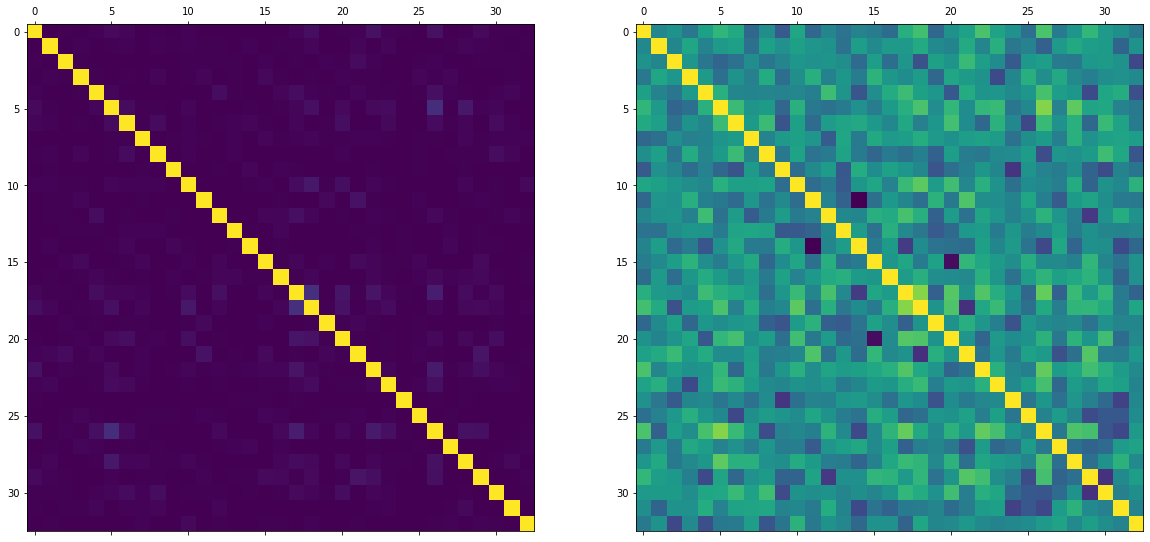

In [ ]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.show()

In [ ]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.13999
Mean:	 0.00824


Mean: -0.0009647013 	Std: 0.99754316
Mean: -0.00696233 	Std: 1.0034336
Mean: -0.009076633 	Std: 0.9709399
Mean: 0.008138002 	Std: 0.9887328
Mean: -0.023156043 	Std: 1.0020286
Mean: -0.008302363 	Std: 1.0004696
Mean: -0.042604342 	Std: 1.0005953
Mean: 0.019951088 	Std: 0.99907553
Mean: -0.0010220112 	Std: 0.99414456
Mean: -0.0015127589 	Std: 0.97649413
Mean: -0.042029917 	Std: 0.97947365
Mean: 0.010218776 	Std: 0.9962337
Mean: 0.027468905 	Std: 0.99015033
Mean: 0.008281067 	Std: 0.98615515
Mean: 0.008963475 	Std: 0.99365443
Mean: 0.015529239 	Std: 0.99213296
Mean: 0.025942551 	Std: 0.99134433
Mean: 0.007498921 	Std: 0.99744695
Mean: 0.0020264764 	Std: 0.9978692
Mean: 0.0024658015 	Std: 0.9888278
Mean: -0.020155001 	Std: 0.9839023
Mean: 0.027472556 	Std: 0.9944144
Mean: 0.021312404 	Std: 1.0193536
Mean: -0.03125393 	Std: 1.016407
Mean: 0.0057564806 	Std: 0.986662
Mean: -0.029221632 	Std: 0.98924506
Mean: -0.027620774 	Std: 1.0219445
Mean: 0.007274961 	Std: 0.99151814
Mean: -0.006428187 	

<ipython-input-10-3e65db6d3c91>:20: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



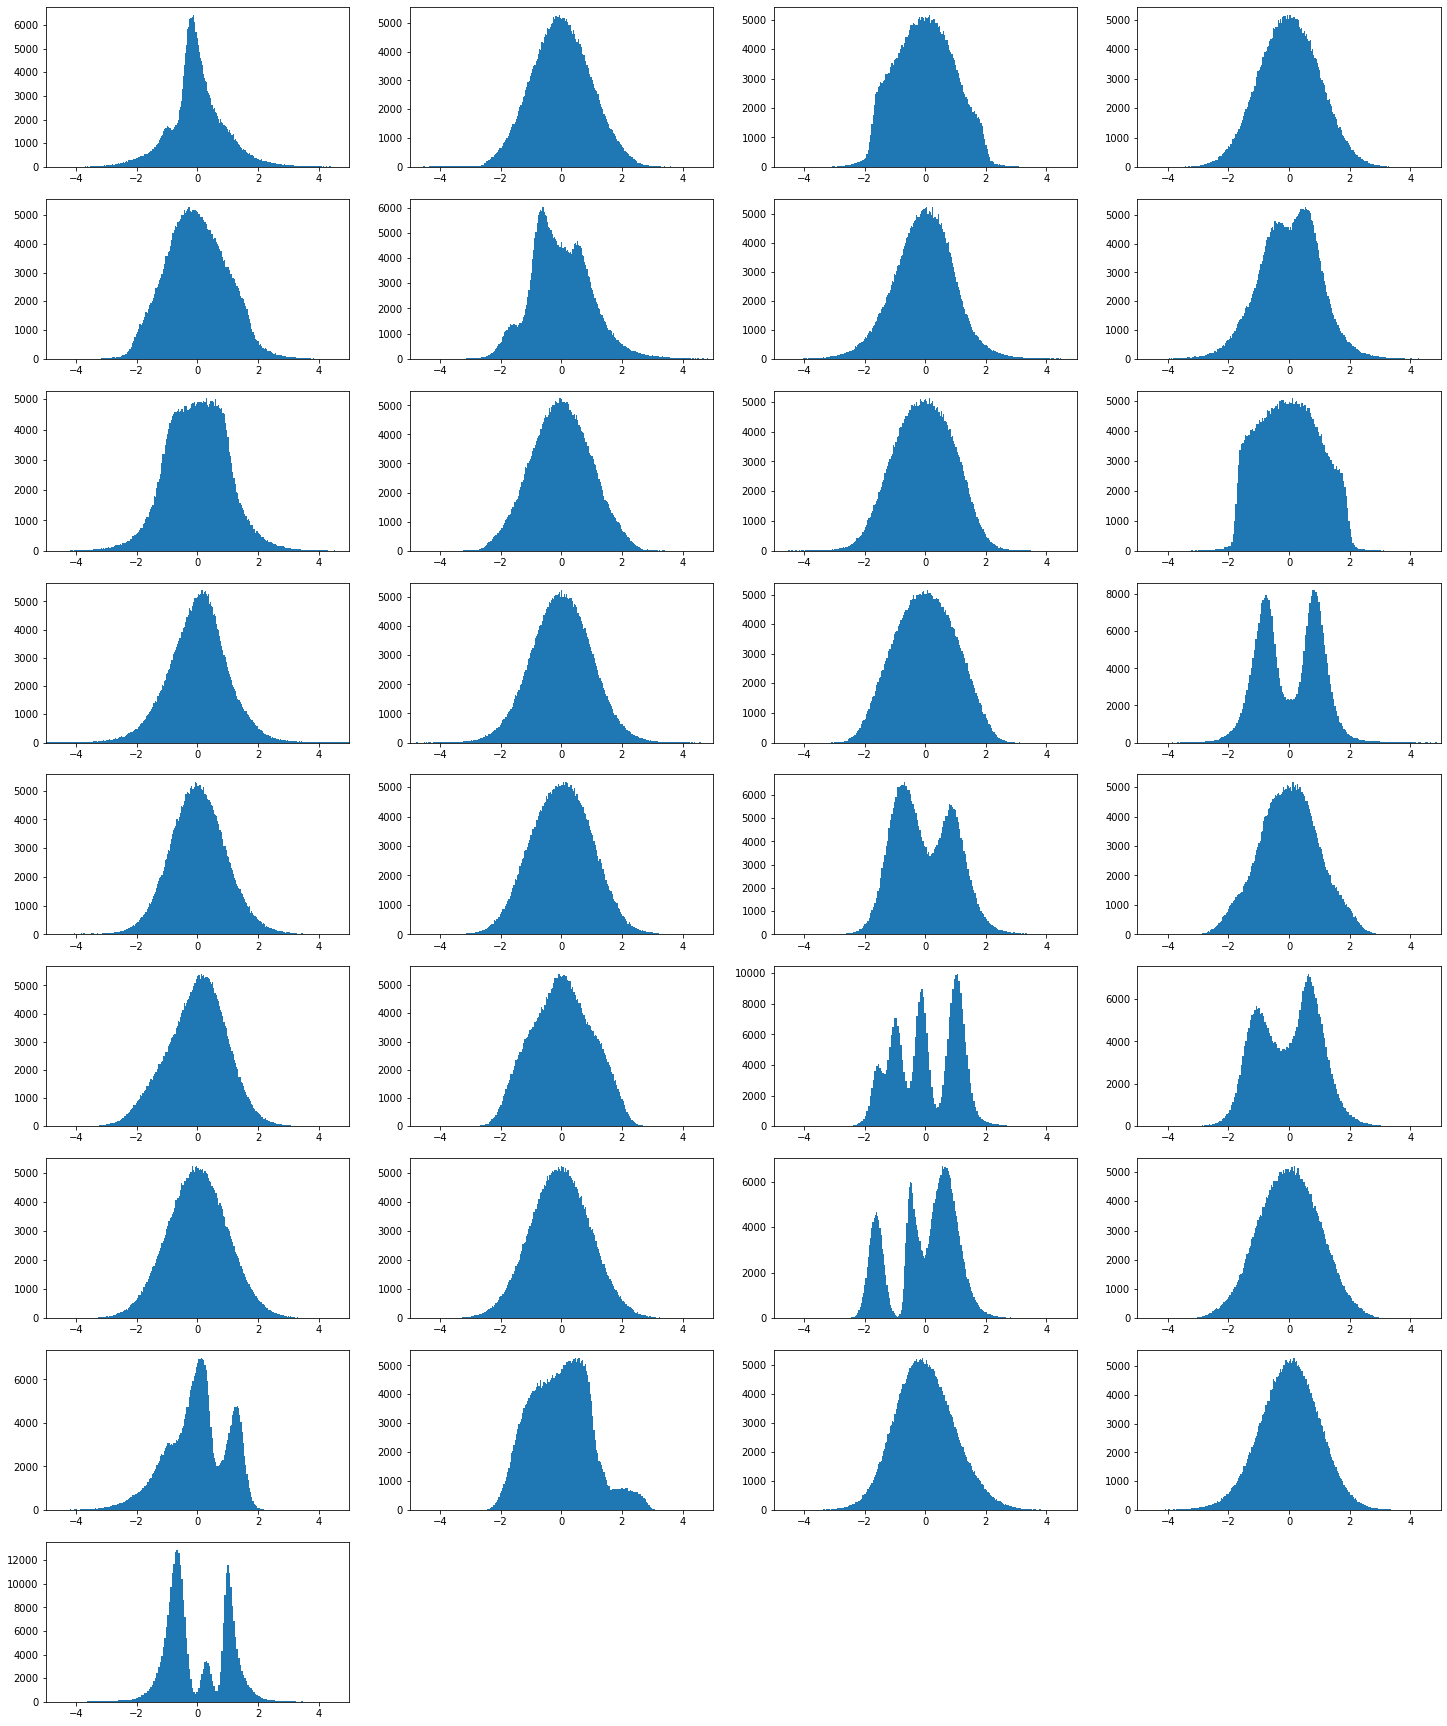

In [ ]:

fig = plt.figure(figsize=[25,70])
i = 0

total_mean = []
total_std = []
for x in range(hidden.shape[1]):
    axes = fig.add_subplot(20,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    total_mean.append(hidden[:, x].mean())
    total_std.append(hidden[:, x].std())
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())

print("\n")
print("Total average mean", np.array(total_mean).mean())
print("Total average std", np.array(total_std).mean())
fig.show()

## Bkg Data vs Random Sampling Decoding

In [ ]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
count,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,...,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000
mean,0.555675,0.224372,0.666965,-0.273888,-0.028457,0.471615,0.287572,0.391323,0.409302,0.394876,...,0.808086,-0.169597,1.133119,0.277678,-0.464093,1.024231,-0.068954,0.175582,-0.557639,-0.372304
std,0.461334,0.286931,0.290969,0.166687,0.345074,0.393169,0.368659,0.386755,0.400676,0.414217,...,0.306372,0.223367,0.359990,0.298334,0.196423,0.383130,0.300331,0.336718,0.463945,0.232477
min,-0.925865,-0.613644,-0.207801,-0.865373,-0.873716,-0.470695,-0.489562,-0.508034,-0.591080,-0.690097,...,-0.193106,-1.043508,-0.018011,-0.659644,-0.978806,0.119522,-0.708914,-0.755177,-1.291395,-1.087570
25%,0.210225,0.015398,0.454063,-0.391221,-0.292389,0.156716,-0.011331,0.054880,0.067146,0.050987,...,0.584993,-0.325212,0.895108,0.060769,-0.605990,0.699474,-0.324457,-0.070719,-1.125916,-0.542758
50%,0.217073,0.225538,0.668783,-0.279136,-0.068648,0.463298,0.247014,0.373329,0.390397,0.372805,...,0.808012,-0.173699,1.198897,0.277595,-0.473099,1.023930,-0.073478,0.170102,-0.216874,-0.390324
75%,1.120180,0.438395,0.877899,-0.162342,0.195796,0.788860,0.525447,0.720348,0.742811,0.728604,...,1.031196,-0.016452,1.407545,0.493374,-0.330892,1.351381,0.177853,0.412151,-0.210561,-0.208522
max,1.286906,1.288319,1.596990,0.511281,1.520705,1.574365,1.991792,1.355550,1.382389,1.458847,...,1.799463,0.693212,1.902564,1.296542,0.374691,1.758929,0.687829,1.235601,0.922259,0.497879


In [ ]:
bkg.shape, sample.shape

((334164, 47), (334164, 47))

In [ ]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += compare_distributions_binned_aux(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("WD_SCORE:", WD_SCORE/len(features))
    #print("WD_Score:", compare_distributions_binned(background, bkg_weights, sample, np.ones(bkg_weights.shape), bins=100))
    #print("R2_SCORE:", R2_SCORE/len(features))

Processing...:   0%|          | 0/47 [00:00<?, ?it/s]

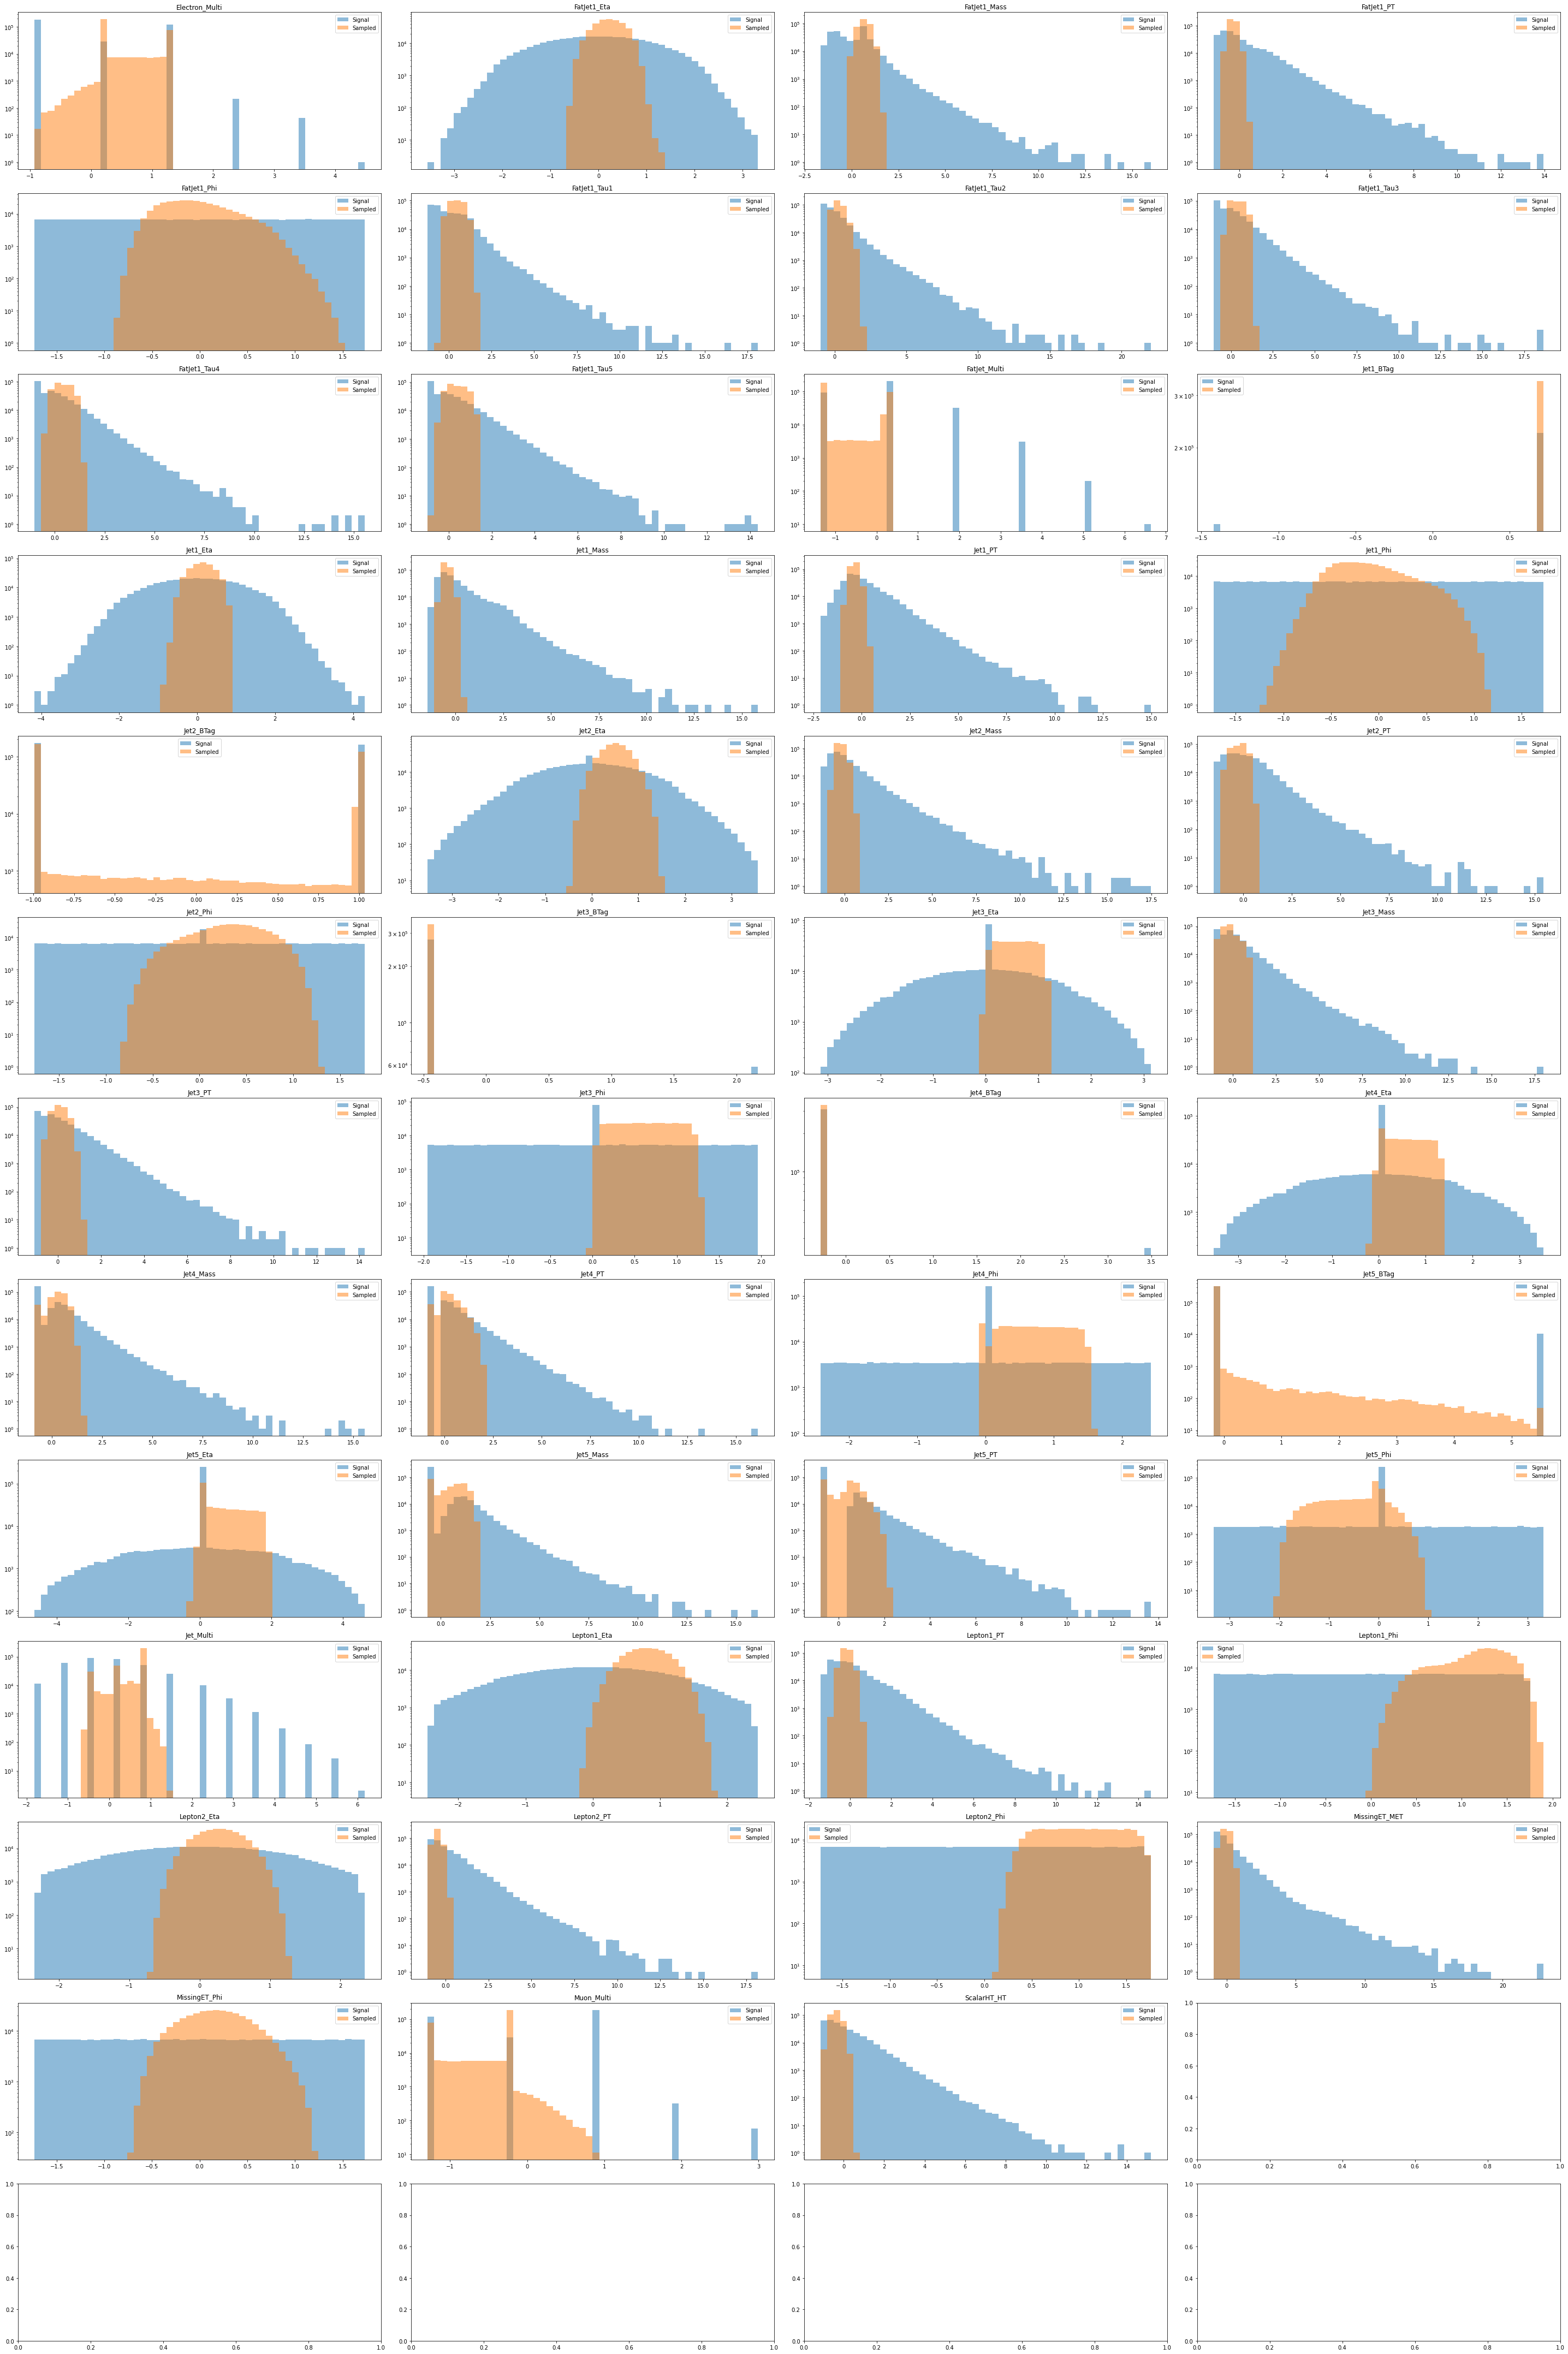

In [ ]:
plot_graphs2(bkg, sample)

In [ ]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

WD Score: 8.515087974494287


## Bkg Data vs Reconstruction

In [ ]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/47 [00:00<?, ?it/s]

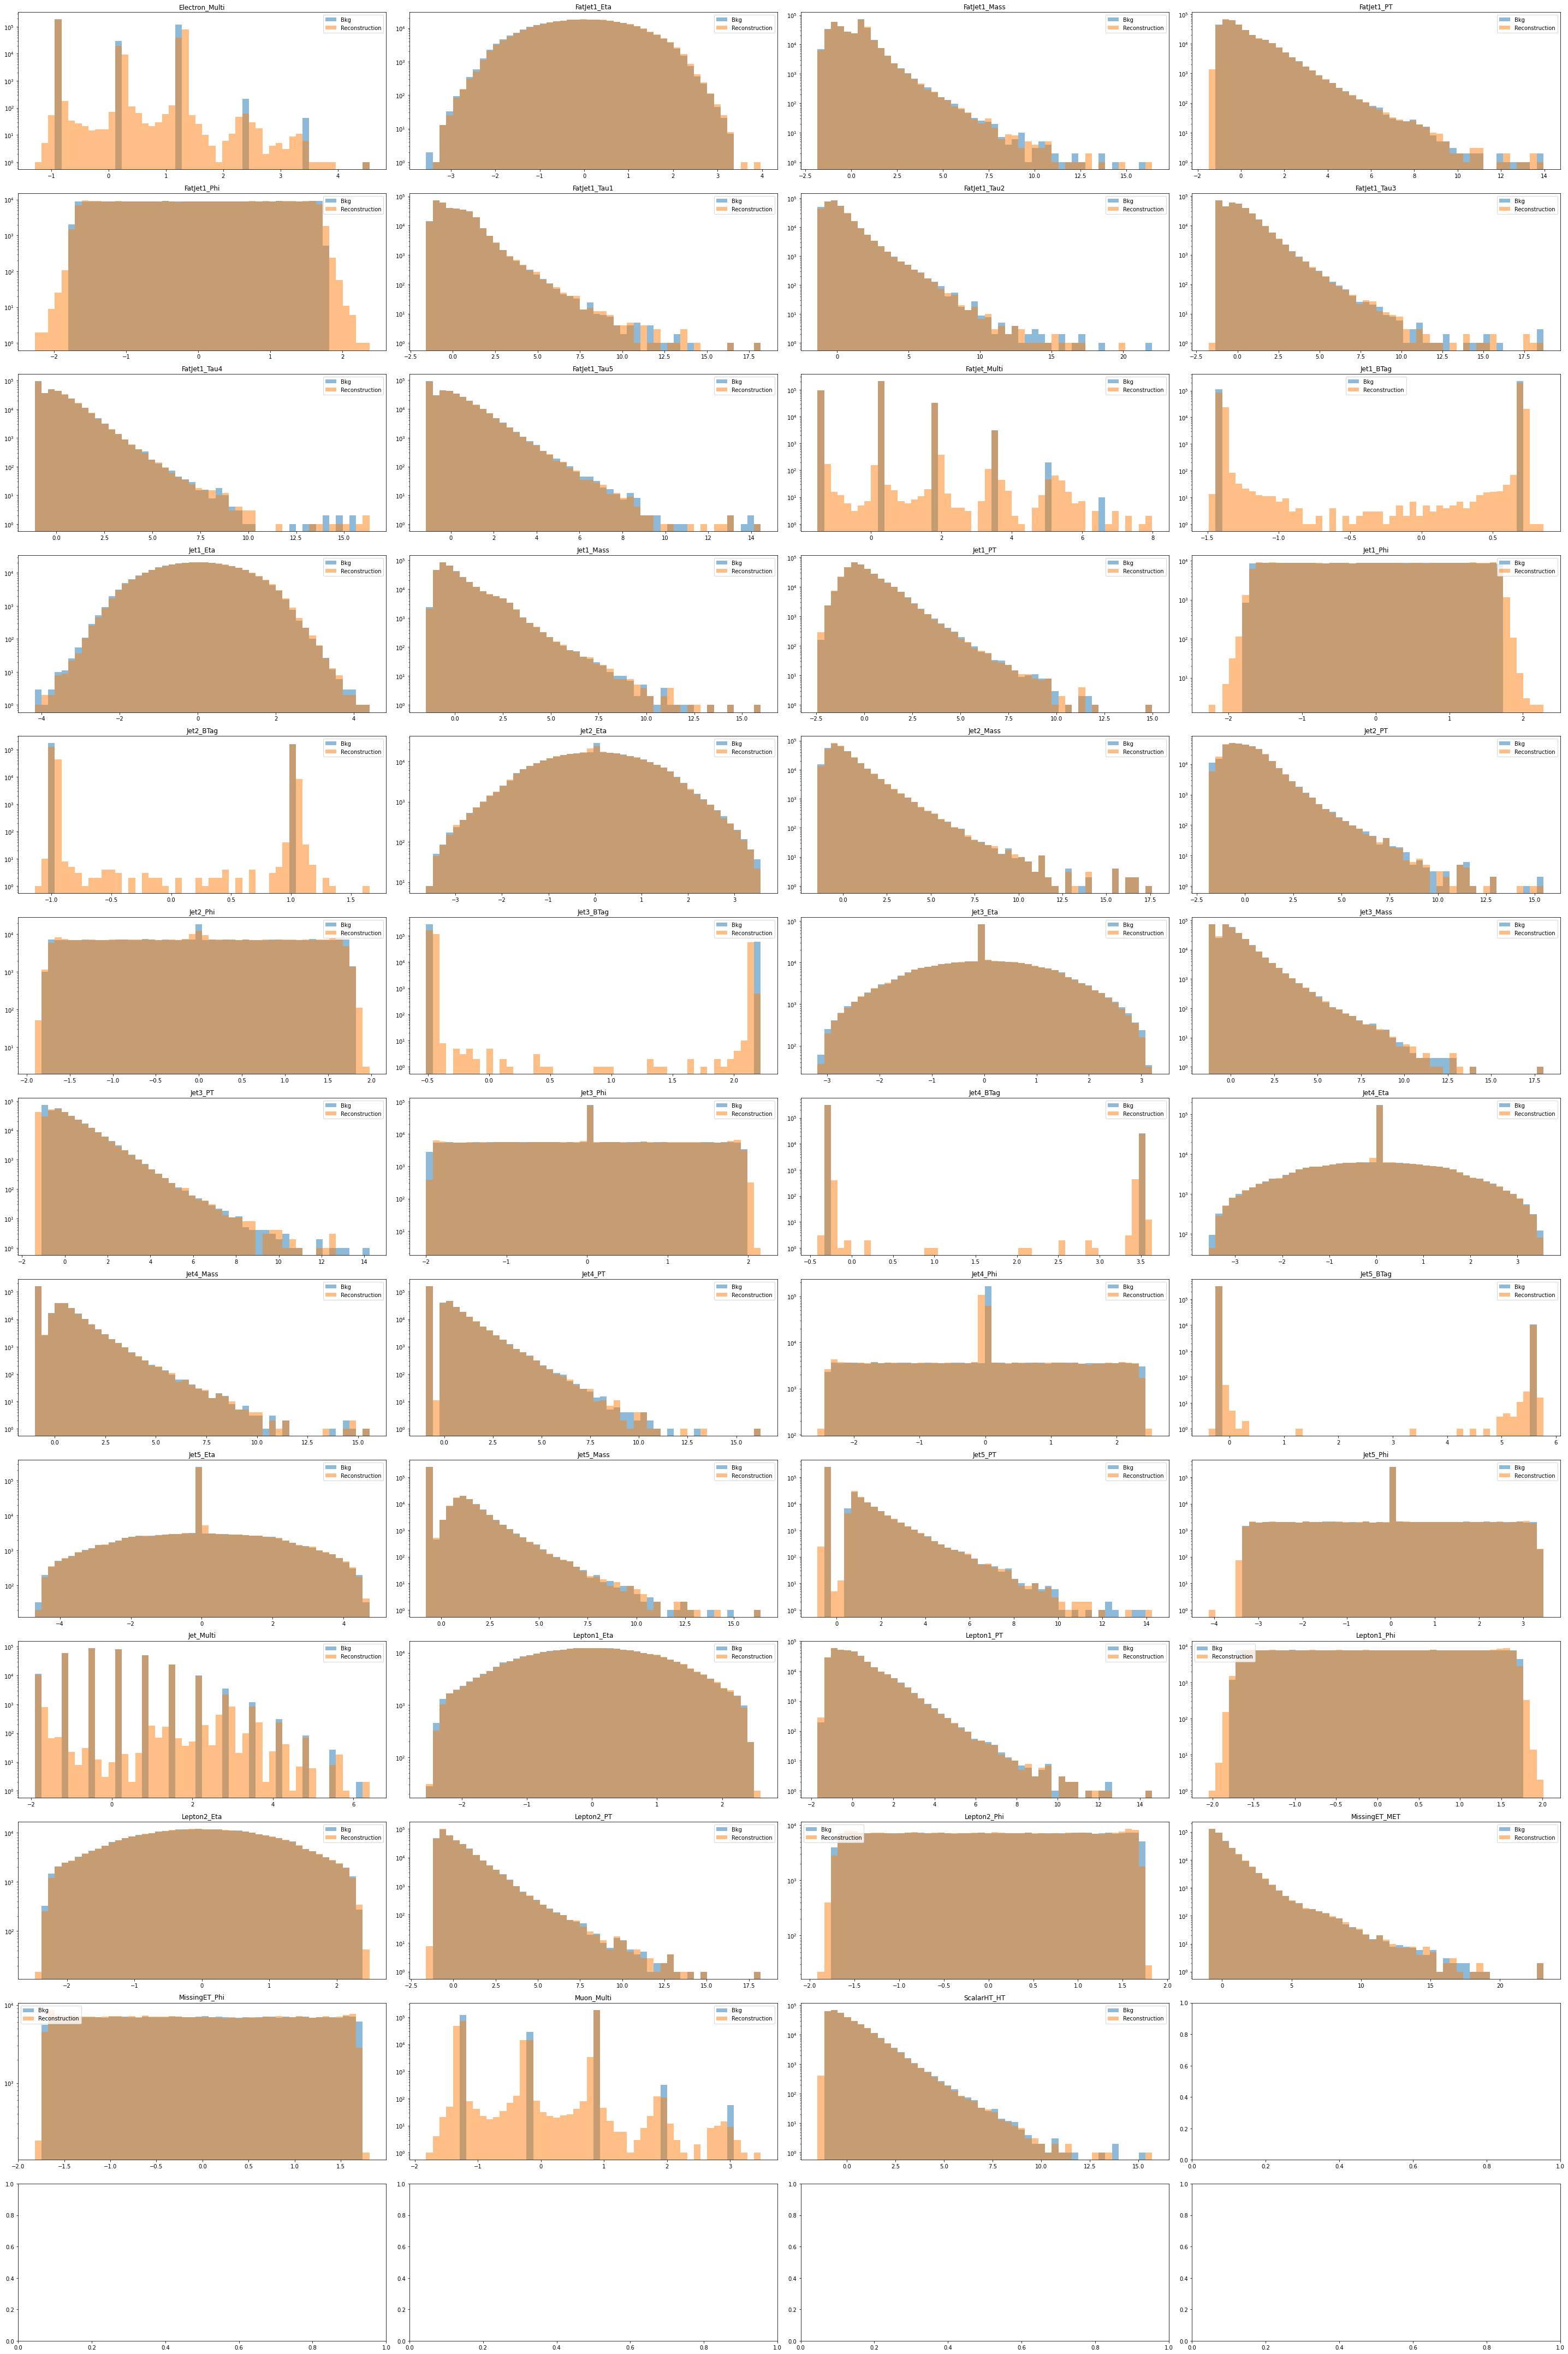

In [ ]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [ ]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

R2 Score: 0.9967058738156152


## Plot error distributions and ROC Score

Load data

In [ ]:
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
signal = _dataset(category='all',variant='signal').all_data()

data = pd.concat([signal, bkg])
del signal, bkg


Plot

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,precision_score

def plot_graphs3(data, bins=50, num_cols=4):
    # Plot creation
    features = list(data['name'].unique())

    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        ## Get the relevant data
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        ## Pass input through model to get the output
        _, _, output, _ = model.test_step(sData)

        ## Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    ## Normalize the distributions
    # This way all values should be between 0 and 1

    # x transform
    min_of_dist = min(map(lambda x: min(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] - min_of_dist
    # scale
    max_of_dist = max(map(lambda x: max(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    
    ## Plot error distributions
    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    ## Plot ROC Curves
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            # Set Scores
            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 

            # Set weights
            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            # Get Curve
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))
            #print(score.min(), score.max())
            #print(np.unique(np.rint(score)))
            print("Confusion matrix:")
            print(confusion_matrix(labels, np.rint(score)))
            print("\n")
    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

0.23132765 0.6616927
0.40101004 0.84089017
0.40726528 0.8974415
0.40372974 1.0
0.409845 0.9900876
0.41059664 0.91683114
0.4017678 0.91316164
0.0 0.7087729


Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

ROC SCORE for fcnc: 0.9951380515812867
0.0 0.7087729
[0. 1.]
Confusion matrix:
[[334113     51]
 [ 89205    873]]


ROC SCORE for hg3000_hq1400: 0.999912971727305
0.0 0.84089017
[0. 1.]
Confusion matrix:
[[334113     51]
 [  3646  21906]]


ROC SCORE for hg3000_hq1200: 0.9999114317161557
0.0 0.8974415
[0. 1.]
Confusion matrix:
[[334113     51]
 [  3798  22756]]


ROC SCORE for wohg_hq1000: 0.9999084504758464
0.0 1.0
[0. 1.]
Confusion matrix:
[[334113     51]
 [  4417  23804]]


ROC SCORE for wohg_hq1200: 0.9999112206900646
0.0 0.9900876
[0. 1.]
Confusion matrix:
[[334113     51]
 [  3891  22570]]


ROC SCORE for hg3000_hq1000: 0.9999091426307666
0.0 0.91683114
[0. 1.]
Confusion matrix:
[[334113     51]
 [  4164  24015]]


ROC SCORE for wohg_hq1400: 0.9999049826392874
0.0 0.91316164
[0. 1.]
Confusion matrix:
[[334113     51]
 [  4126  21031]]




<ipython-input-16-32be59363ed8>:99: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



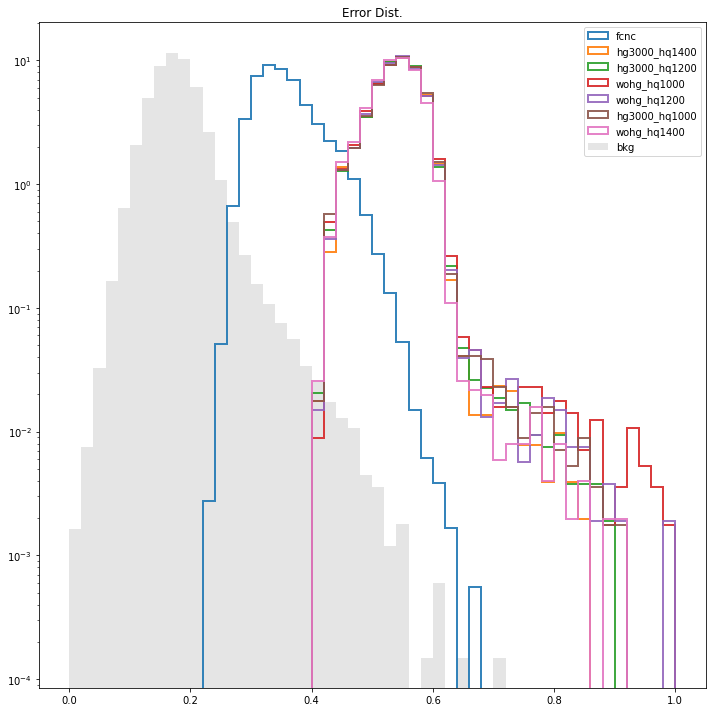

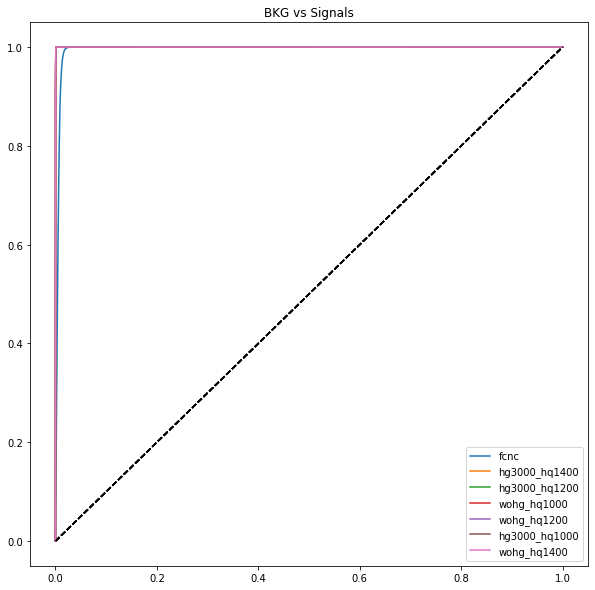

In [ ]:
plot_graphs3(data)